In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Installing the ucimlrepo Package  
The `ucimlrepo` package fetches datasets from the UCI Machine Learning Repository.

In [90]:
# pip install ucimlrepo

### Dataset Import  
The air quality dataset is fetched and loaded for analysis.

In [92]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
data = air_quality.data.features
# data

### Replace Invalid Values  
Replaces invalid values (`-200`) in the dataset with `NaN` to properly handle missing data during preprocessing.

In [94]:
data = data.replace(-200, np.nan)

### Compute Missing Values  
Calculates the number of missing values for each column in the dataset and prints the result for inspection.

In [96]:
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


### Compute Missing Percentage  
Calculates the percentage of missing values for each column and displays the result to assess data completeness.

In [98]:
missing_percentage = (missing_values / len(data)) * 100
print("Percentage of missing values per column:")
print(missing_percentage)

Percentage of missing values per column:
Date              0.000000
Time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64


### Drop Unnecessary Columns 

In [100]:
data = data.drop(columns=['Date', 'Time', 'NMHC(GT)'])
# data

### Perform Median Imputation  
Replaces missing values in specific columns (`CO(GT)`, `NOx(GT)`, `NO2(GT)`) with the median of those columns.

In [102]:
target_columns = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']
data[target_columns] = data[target_columns].fillna(data[target_columns].median())

### Perform Mean Imputation  
Handles missing values in other columns by replacing them with the mean of the respective column.

In [104]:
target_columns = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
data[target_columns] = data[target_columns].fillna(data[target_columns].mean())

### Validate Imputation  
Verifies that no missing values remain in the dataset after the imputation process.

In [106]:
print("Remaining missing values:", data.isnull().sum().sum())

Remaining missing values: 0


### Split Dataset  
Shuffles the dataset to prevent bias, then splits it into training (75%) and testing (25%) subsets for model development.

In [108]:
split_index = int(len(data) * 0.75)

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

### Define Features and Target  
Separates the feature columns (`X`) and the target variable (`T`) for both the training and testing datasets.

In [110]:
X_train = train_data.drop(['T'], axis=1)
y_train = train_data['T']

X_test = test_data.drop(['T'], axis=1)
y_test = test_data['T']

### Define & Apply Normalization  
Defines functions to normalize data using min-max scaling. One function normalizes specific columns in a DataFrame, and another handles a single column or series. Normalizes both features and target variables in the training and testing datasets to bring all values to a similar scale.

In [112]:
def min_max_normalization(df, columns):
    normalized_df = df.copy()
    for column in columns:
        col_min = df[column].min()
        col_max = df[column].max()
        normalized_df[column] = (df[column] - col_min) / (col_max - col_min)
    return normalized_df

def min_max_normalization_single_column(series):
    col_min = series.min()
    col_max = series.max()
    return (series - col_min) / (col_max - col_min)

columns_to_scale = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)',	'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH']

X_train = min_max_normalization(X_train, columns_to_scale)
X_test = min_max_normalization(X_test, columns_to_scale)

y_train = min_max_normalization_single_column(y_train)
y_test = min_max_normalization_single_column(y_test)

### Reshape Target Values  
Defines a function to reshape the target variables into column vectors, ensuring compatibility with matrix operations.

In [114]:
def reshape_to_column_vector(y):
    if not isinstance(y, np.ndarray):
        return y.values.reshape(-1, 1)
    else:
        return y.reshape(-1, 1)

### Linear Regression Model  
Implements a linear regression model. Uses gradient descent for optimization and calculates the mean squared error (MSE) to evaluate performance.

In [116]:
def train_linear_regression(X_train, y_train, X_test, y_test, iterations, learning_rate):
    import matplotlib.pyplot as plt

    rows, columns = X_train.shape
    weight = np.ones([columns, 1])
    bias = 0

    y_train = reshape_to_column_vector(y_train)
    y_test = reshape_to_column_vector(y_test)

    m = len(y_train)
    costs = []

    for i in range(iterations):
        y_hat = np.dot(X_train, weight) + bias
        error = y_hat - y_train

        dw = np.dot(X_train.T, error) / m
        db = np.sum(error) / m

        weight = weight - learning_rate * dw
        bias = bias - learning_rate * db

        cost = np.sum(np.square(error)) / (2 * m)
        costs.append(cost)

    # Plot cost vs iterations
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(costs) + 1), costs, label="Training Cost", color="blue")
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.title("Cost vs Iterations")
    plt.legend()
    plt.grid()
    plt.show()

    # Predictions for Train Data
    y_train_hat = np.dot(X_train, weight) + bias
    train_mse = np.sum(np.square(y_train_hat - y_train)) / (2 * m)

    # Predictions for Test Data
    y_test_hat = np.dot(X_test, weight) + bias
    m_test = len(y_test)
    test_mse = np.sum(np.square(y_test_hat - y_test)) / (2 * m_test)

    # Predicted vs Actual for Training Data
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_train_hat, color="blue", label="Train Data", alpha=0.7)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label="Perfect Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual (Training Data)")
    plt.legend()
    plt.grid()
    plt.show()

    # Predicted vs Actual for Test Data
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_hat, color="green", label="Test Data", alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs Actual (Test Data)")
    plt.legend()
    plt.grid()
    plt.show()

    return weight, bias, train_mse, test_mse

### Train the Model  
Trains the regression model and evaluates its performance on the training and testing datasets.

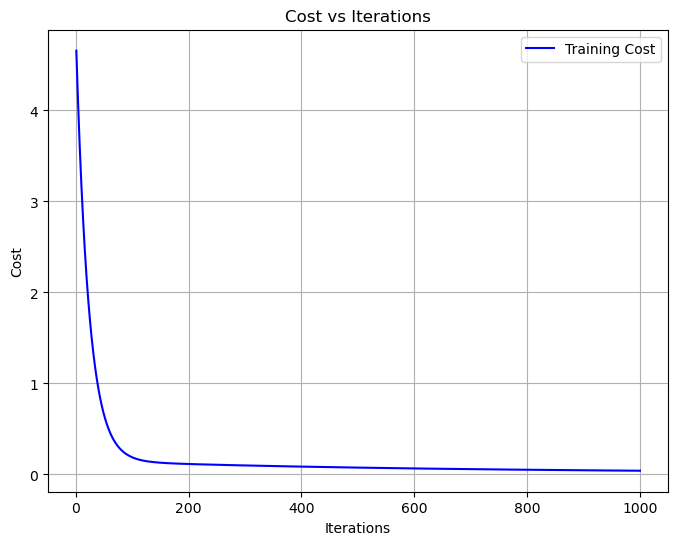

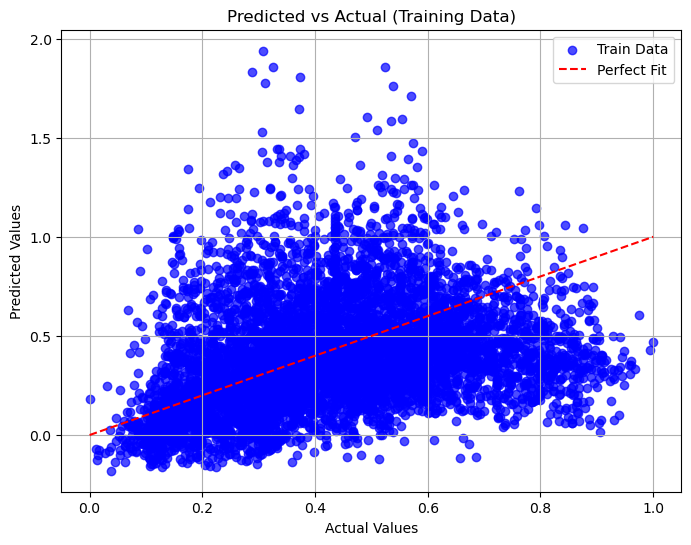

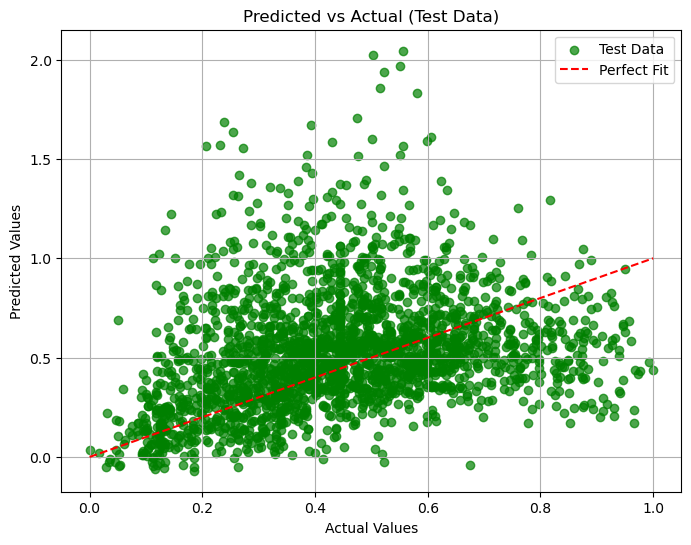

Train MSE: 0.04059245303795161
Test MSE: 0.04955245207216096


In [118]:
weight, bias, train_mse, test_mse = train_linear_regression(
    X_train, y_train, X_test, y_test, iterations = 1000, learning_rate = 0.01)

# print("Final Weights:\n", weight)
# print("Final Bias:", bias)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)